In [48]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [49]:
# Load the dataset
df = pd.read_csv('train.csv')

In [88]:
# df.head()

In [50]:
# Drop unnecessary columns (like 'id' and 'Unnamed: 0')
df = df.drop(columns=['Unnamed: 0', 'id'])

In [51]:
# Handle missing values (e.g., row 213 has a NaN)
imputer = SimpleImputer(strategy='median')
df['Arrival Delay in Minutes'] = imputer.fit_transform(df[['Arrival Delay in Minutes']])


In [52]:
# Separate features and target
X = df.drop(columns=['satisfaction'])
y = df['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}).values

# Preprocess data: Encode categorical features and scale numerical ones
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_features = [col for col in X.columns if col not in categorical_features + ['satisfaction']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

In [53]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [55]:
# Convert to PyTorch tensors
# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

In [56]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [57]:
# Define the neural network
class SatisfactionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)


In [58]:
#Initialize model, loss, and optimizer
input_dim = X_train.shape[1]
model = SatisfactionModel(input_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [89]:
from sklearn.metrics import classification_report

epochs = 100
best_val_accuracy = 0
all_preds = []
all_labels = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_accuracy:.4f}')

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# After training, print classification report
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print('Classification Report:')
print(classification_report(all_labels, all_preds))


Epoch 1/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 2/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 3/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 4/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 5/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 6/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 7/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 8/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 9/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 10/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 11/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 12/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 13/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 14/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 15/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 16/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 17/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 18/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 19/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 20/100 | Val Loss: 0.0828 | Val Acc: 0.9642
Epoch 21/

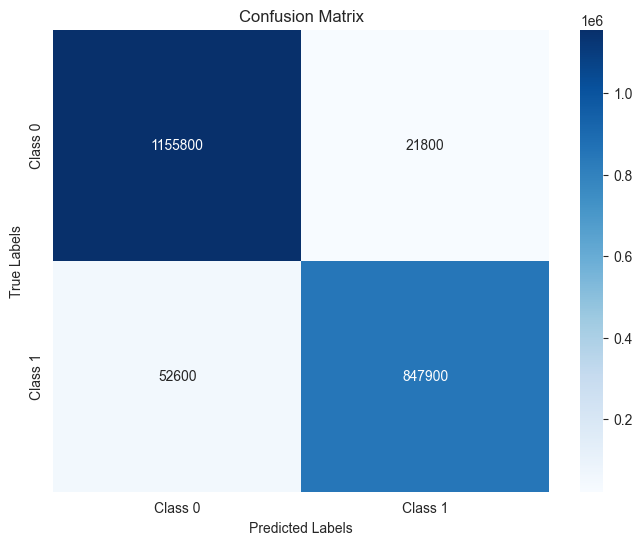

In [90]:
# Compute confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
import pandas as pd

# Load the training data and create a sample without the target column
df = pd.read_csv('train.csv')
sample = df.drop(columns=['satisfaction']).head(5)  # Take first 5 rows
sample.to_csv('sample.csv', index=False)

In [87]:
# Load trained model
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load dataset to get feature names
df = pd.read_csv("train.csv")
df = df.drop(columns=['Unnamed: 0', 'id'])

# Define categorical and numerical features
categorical_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_features = [col for col in df.columns if col not in categorical_features + ['satisfaction']]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit preprocessor on full dataset (excluding target)
X_full = df.drop(columns=['satisfaction'])
preprocessor.fit(X_full)

# Define model architecture
class SatisfactionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)
input_dim = preprocessor.transform(X_full[:1]).shape[1]
model = SatisfactionModel(input_dim)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load and preprocess sample.csv
sample_df = pd.read_csv("sample.csv")
X_sample = preprocessor.transform(sample_df)

# Convert to PyTorch tensor
X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    outputs = model(X_sample_tensor).squeeze()
    predictions = (torch.sigmoid(outputs) > 0.5).int().numpy()

# Add predictions to the DataFrame
sample_df['Predicted Satisfaction'] = predictions
sample_df['Predicted Satisfaction'] = sample_df['Predicted Satisfaction'].map({1: 'satisfied', 0: 'neutral or dissatisfied'})

# Save results
sample_df.to_csv("result.csv", index=False)
print("Predictions saved to result.csv")

Predictions saved to result.csv
